In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False
    
# Progress bar
from tqdm.auto import trange, tqdm

In [3]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S, source_spectrum

from astropy.io import fits

pynrc.setup_logging('WARNING', verbose=False)

In [4]:
import pysiaf
siaf_nrc = pysiaf.Siaf('NIRCam')
siaf_nrc.generate_toc()

In [5]:
# Observation Definitions
from pynrc.nb_funcs import make_key

from pynrc.maths.image_manip import rotate_offset
from pynrc.maths.coords import rtheta_to_xy, v2v3_to_pixel
from pynrc.maths.image_manip import optimal_difference, scale_ref_image
from pynrc.maths.image_manip import pad_or_cut_to_size, fshift, frebin, fourier_imshift
from pynrc import robust
from pynrc.nrc_utils import radial_std

# Functions

In [351]:
def gen_image(nrc, sp1, sp2, age_sci, dist_sci, sky_sep=1, sky_pa=45, roll=0, 
              rth_pl=None, mass_pl=None, center_lw=False, wfe_drift=0, 
              no_bdi=False, **kwargs):
    
    siaf_ap = nrc.siaf_ap
    oversample = nrc.psf_info['oversample']
    ny, nx = nrc.Detectors[0].ypix, nrc.Detectors[0].ypix
    
    # Determine V2/V3 locations to place each stellar component
    siaf_ap = nrc.siaf_ap

    coords0_v2v3 = np.array(siaf_ap.reference_point('tel'))
    coords1_v2v3 = coords0_v2v3 + rtheta_to_xy(sky_sep/2, sky_pa+roll)
    coords2_v2v3 = coords0_v2v3 + rtheta_to_xy(-sky_sep/2, sky_pa+roll)

    # Four-position dither pattern
    delx_asec = np.array([0, 5.0, 2.5, 7.5])*0.032 
    dely_asec = np.array([0, 5.0, 2.5, 7.5])*0.032

    # Dither locations in V2/V3
    dith0_v2v3 = coords0_v2v3.reshape([-1,1]) + np.array([delx_asec, dely_asec])
    dith1_v2v3 = coords1_v2v3.reshape([-1,1]) + np.array([delx_asec, dely_asec])
    dith2_v2v3 = coords2_v2v3.reshape([-1,1]) + np.array([delx_asec, dely_asec])

    # Convert to pixel locations
    xdith0, ydith0 = siaf_ap.tel_to_sci(dith0_v2v3[0], dith0_v2v3[1])
    xdith1, ydith1 = siaf_ap.tel_to_sci(dith1_v2v3[0], dith1_v2v3[1])
    xdith2, ydith2 = siaf_ap.tel_to_sci(dith2_v2v3[0], dith2_v2v3[1])
    if center_lw:
        dx = nx/2 - xdith0[0]
        dy = ny/2 - ydith0[0]
        xdith0 += dx; xdith1 += dx; xdith2 += dx; 
        ydith0 += dy; ydith1 += dy; ydith2 += dy; 
    
    if (wfe_drift>0) and (nrc.wfe_drift==False):
        nrc.wfe_drift = True
    
    # Create PSFs centered in image
    psf1, psf1_over = nrc.gen_psf(sp1, coord_vals=coords1_v2v3, return_oversample=True, wfe_drift=wfe_drift)
    psf2, psf2_over = nrc.gen_psf(sp2, coord_vals=coords2_v2v3, return_oversample=True, wfe_drift=wfe_drift)
    
    # Make subarray window size
    psf1 = pad_or_cut_to_size(psf1, (ny,nx))
    psf2 = pad_or_cut_to_size(psf2, (ny,nx))
    psf1_over = pad_or_cut_to_size(psf1_over, (ny*oversample,nx*oversample))
    psf2_over = pad_or_cut_to_size(psf2_over, (ny*oversample,nx*oversample))

    # Determine pixel shift amounts for dither positions
    xsh1, ysh1 = (xdith1 - nx/2, ydith1 - ny/2)
    xsh2, ysh2 = (xdith2 - nx/2, ydith2 - ny/2)
    # Pixel shifts for oversampled PSFs
    xsh1_over, ysh1_over = np.array([xsh1, ysh1])*oversample
    xsh2_over, ysh2_over = np.array([xsh2, ysh2])*oversample
    
    # Add in exoplanet position relative to source 2
    if (rth_pl is not None) and (mass_pl is not None):
        
        # Read in Linder models
        tbl = nrc_utils.linder_table()
        mass_mjup, mag_vals = nrc_utils.linder_filter(tbl, nrc.filter, age_sci, dist=dist_sci)
        # Sort by mass
        isort = np.argsort(mass_mjup)
        mass_mjup = mass_mjup[isort]
        mag_vals = mag_vals[isort]
        
        shape_oversample = (ny*oversample,nx*oversample)
        imarr_pl_over = np.zeros([4,shape_oversample[0],shape_oversample[1]])
        for i, (r_pl, th_pl) in enumerate(rth_pl):
            # r_pl, th_pl = (0.5, 45)  # (arcsec, deg)
            imass_mjup = mass_pl[i]
            x_pl, y_pl = rtheta_to_xy(r_pl/nrc.pix_scale, th_pl+roll)  # detector sampled pixels
            # Oversample pixel shift positions
            xsh_pl_over, ysh_pl_over = (xsh2_over + x_pl*oversample, ysh2_over + y_pl*oversample)

            # Get planet magnitude
            mag_pl = np.interp(imass_mjup, mass_mjup, mag_vals)
            sp_pl = pynrc.stellar_spectrum('flat', mag_pl, 'vegamag', nrc.bandpass)

            # Companion PSF (don't care about WFE field)
            psf_pl, psf_pl_over = nrc.gen_psf(sp_pl, return_oversample=True)
            # Make subarray window size
            psf_pl = pad_or_cut_to_size(psf_pl, (ny,nx))
            psf_pl_over = pad_or_cut_to_size(psf_pl_over, shape_oversample)

            imarr_pl_over += np.array([fshift(psf_pl_over, xsh, ysh, pad=True) 
                                       for xsh, ysh in zip(xsh_pl_over, ysh_pl_over)])
    else:
        imarr_pl_over = 0

    # Create oversampled detector image
    imarr1_over = np.array([fshift(psf1_over, xsh, ysh, pad=True) 
                            for xsh, ysh in zip(xsh1_over, ysh1_over)])
    imarr2_over = np.array([fshift(psf2_over, xsh, ysh, pad=True) 
                            for xsh, ysh in zip(xsh2_over, ysh2_over)])

    # Add and crop
    imarr_over = imarr1_over + imarr2_over + imarr_pl_over
    imarr_over = pad_or_cut_to_size(imarr_over, nx*oversample)

    # Rebin to detector pixels
    imarr_slope = np.array([frebin(im, scale=1/oversample) for im in imarr_over])

    # Add Zodiacal light
    imarr_slope += nrc.bg_zodi(**kwargs)
    
    # Add noise to each dither position
    det = nrc.Detectors[0]
    noise_vals = np.array([det.pixel_noise(fsrc=im) for im in imarr_slope])
    imarr_slope += np.random.normal(scale=noise_vals)
        
    # Shift sci reference point to center
    if center_lw:
        imarr_crop = imarr_slope
    else:
        xref, yref = siaf_ap.reference_point('sci')
        xsh, ysh = (int(nx/2 - xref), int(ny/2 - yref))
        imarr_crop = np.array([fshift(im, xsh, ysh) for im in imarr_slope])
        # nxy_new = np.min([2*int(nx-xref), 2*int(ny-yref)])
        # imarr_crop = pad_or_cut_to_size(imarr_slope, (nxy_new,nxy_new), offset_vals=(ysh,xsh))
    
    # Rebin and shift by offsets
    imarr_crop_over = np.array([frebin(im, scale=oversample) for im in imarr_crop])

    # Perform Gaussian smooth
    from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
    kernel = Gaussian2DKernel(0.65*oversample, x_size=100, y_size=100)
    imarr_crop_over = np.array([convolve_fft(im, kernel, allow_huge=True)
                                for im in imarr_crop_over])
    # imarr_crop_over = np.array([convolve(im, kernel) for im in imarr_crop_over])

    
    xsh = -(xdith0 - xdith0[0])*oversample
    ysh = -(ydith0 - ydith0[0])*oversample
    imarr_crop_over_sh = np.array([fshift(im, xsh[i], ysh[i])
                                   for i, im in enumerate(imarr_crop_over)])

    # Average all dithers together
    im_crop_over = np.mean(imarr_crop_over_sh, axis=0)
    
    # Crop around each component
    xoff1, yoff1 = (xdith1[0] - xdith0[0])*oversample, (ydith1[0] - ydith0[0])*oversample
    xoff2, yoff2 = (xdith2[0] - xdith0[0])*oversample, (ydith2[0] - ydith0[0])*oversample

    pix_osamp = nrc.pix_scale / oversample
    npix_osamp = int(1.5 * sky_sep / pix_osamp)
    shape = (npix_osamp,npix_osamp)
    im1_crop_over = pad_or_cut_to_size(im_crop_over, shape, offset_vals=(-yoff1,-xoff1))
    im2_crop_over = pad_or_cut_to_size(im_crop_over, shape, offset_vals=(-yoff2,-xoff2))
    
    if no_bdi:
        return imarr_slope[0], im2_crop_over
    
    # Create differenced image by scaling PSF by total counts
    obs1 = S.Observation(sp1, nrc.bandpass, binset=nrc.bandpass.wave)
    obs2 = S.Observation(sp2, nrc.bandpass, binset=nrc.bandpass.wave)
    scl = obs2.countrate() / obs1.countrate()
    diff = im2_crop_over - im1_crop_over*scl
    
    # Subtract other binary PSF
    sub_val = np.median(im_crop_over)
    # First trim off border pixels
    shape_trim = [im_crop_over.shape[0]-4, im_crop_over.shape[1]-4]
    im_crop_over_trim = pad_or_cut_to_size(im_crop_over, shape_trim)    
    imsub_off_psf = pad_or_cut_to_size(im_crop_over_trim, shape, fill_val=sub_val,
                                       offset_vals=(-2*yoff2+yoff1,-2*xoff2+xoff1))
    # Subtract median background value
    imsub_off_psf -= sub_val
    diff_alt = diff - imsub_off_psf / scl
    
    # Return differenced image
    return imarr_slope[0], diff_alt




In [69]:
def gen_roll_diff(*args, delta_roll=10, wfe_roll_drift=0, **kwargs):
    """
    For args and kwargs, see:
        gen_image(nrc, sp1, sp2, age_sci, dist_sci, sky_sep=1, sky_pa=45, roll=0, 
                  rth_pl=None, mass_pl=None, center_lw=False, **kwargs)
    
    """
    
    delta_roll = np.abs(delta_roll)
    pa1 = -delta_roll / 2.0
    pa2 = pa1 + delta_roll
    
    # Position angle 1
    res = gen_image(*args, roll=pa1, **kwargs)
    im_slope1, diff1 = res

    # Position angle 2
    res = gen_image(*args, roll=pa2, wfe_drift=wfe_roll_drift, **kwargs)
    im_slope2, diff2 = res

    # Average of two roll positions, reference subtracted
    diff1_derot = rotate_offset(diff1, angle=pa1, reshape=False)
    diff2_derot = rotate_offset(diff2, angle=pa2, reshape=False)
    diff_avg = (diff1_derot + diff2_derot) / 2
    
    # Average of two roll positions, ref subtracted, and roll subtracted
    roll_sub1 =  rotate_offset(diff1 - diff2, angle=pa1, reshape=False)
    roll_sub2 =  rotate_offset(diff2 - diff1, angle=pa2, reshape=False)
    diff_roll_sub = (roll_sub1 + roll_sub2)/2
    
    return im_slope1, diff_avg, diff_roll_sub



In [380]:
def psf_max_vals(nrc, rr, psf=None):
    
    off_vals = []
    max_vals = []
    rpix_max = nrc.det_info['xpix'] / np.sqrt(2)
    rvals_pix = np.insert(np.arange(1,rpix_max,2), 0, 0.1)
    pixscale = nrc.pix_scale
    
    if psf is None:
        psf = nrc.gen_psf()

    for j, roff_pix in enumerate(rvals_pix):
        roff_asec = roff_pix * pixscale
        psf1 = psf.copy()
        psf2 = psf.copy()

        psf1 = fshift(psf1, delx=0, dely=roff_pix, pad=False)
        xoff, yoff = nrc_utils.xy_rot(0, roff_pix, 10)
        psf2 = fshift(psf2, delx=xoff, dely=yoff, pad=False)

        diff = psf1 - psf2
        maxv = diff.max()

        off_vals.append(roff_pix)
        max_vals.append(maxv)
        if maxv >= 0.95*psf1.max():
            off_vals = off_vals + [roff_pix+5, xpix/2]
            max_vals = max_vals + [psf1.max(), psf1.max()]
            break

    max_vals = np.array(max_vals)
    off_asec = np.array(off_vals) * pixscale

    # #psf_max = np.interp(rr, off_asec, max_vals)
    psf_max_log = np.interp(rr, off_asec, np.log10(max_vals))
    psf_max = 10**psf_max_log
    
    return psf_max

def gen_contrast(nrc, image, sp, roll_sub=False, nsig=5, std_func=np.std, psf=None):
    
    obs = S.Observation(sp, nrc.bandpass, binset=nrc.bandpass.wave)

    # Get contrast curves
    oversample = nrc.psf_info['oversample']
    pix_osamp = nrc.pix_scale / oversample
    rr, stds = radial_std(image, pixscale=pix_osamp, oversample=oversample, 
                          supersample=False, func=std_func)

    if psf is None:
        psf = nrc.gen_psf(return_oversample=False)
        
    if roll_sub:
        psf_max = psf_max_vals(nrc, rr, psf=psf)
    else:
        psf_max = psf.max()

    texp  = nrc.multiaccum_times['t_exp']
    p     = 1 / texp
    crate = (p*nsig**2 + nsig * np.sqrt((p*nsig)**2 + 4*stds**2)) / 2
    # Get total count rate
    crate /= psf_max

    # Compute contrast
    contrast = crate / obs.countrate()

    # Magnitude sensitivity
    star_mag = obs.effstim('vegamag')
    sen_mag = star_mag - 2.5*np.log10(contrast)
    
    return rr, contrast, sen_mag

def get_contrast_mass(filter, mag_sens_arr, dist_sci, age_sci):
    
    # Convert from magnitudes to mass based on age, distance, and models

    # Read in Linder models
    tbl = nrc_utils.linder_table()
    mass_data, mag_data = nrc_utils.linder_filter(tbl, filter, age_sci, dist=dist_sci)
    # Sort by mags
    isort = np.argsort(mag_data)
    
    # Interpolate in log space
    xv, yv = mag_data[isort], np.log10(mass_data[isort])
    xint = mag_sens_arr
    
    try:
        mass_arr = 10**np.interp(xint, xv, yv)
    except:
        mass_arr = [10**np.interp(x, xv, yv) for x in xint]

    return mass_arr

In [71]:
def contrast_contour_map(nrc, sp1, sp2, nsig=5, sample_dist=0.5, wfe_roll_drift=0, do_roll=True,
                         kmag_grid=np.arange(7,16), sep_grid=np.arange(1,5.5,0.5),
                         std_func=np.std):
        
    psf = nrc.gen_psf(return_oversample=False)
    mag_sens_grid = []
    for kmag in tqdm(kmag_grid, leave=False):

        sp1_renorm = sp1.renorm(kmag, 'vegamag', bp_k)
        sp2_renorm = sp2.renorm(kmag, 'vegamag', bp_k)

        row = []
        for sky_sep in tqdm(sep_grid, leave=False):
            
            if do_roll:
                _, diff, _ = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, None, None,
                                           sky_sep=sky_sep, center_lw=True, delta_roll=10,
                                           wfe_roll_drift=wfe_roll_drift)
            else:
                _, diff = gen_image(nrc, sp1_renorm, sp2_renorm, None, None,
                                    sky_sep=sky_sep, center_lw=True)
                
            res = gen_contrast(nrc, diff, sp2_renorm, nsig=nsig, psf=psf, std_func=std_func)

            rr, contrast, mag_sens = res
            # Interpolate at desired radial distance
            row.append(np.interp(sample_dist, rr, mag_sens))

        mag_sens_grid.append(row)

    return np.array(mag_sens_grid)


In [72]:
def plot_contours(ax, mass_sens_grid, xvals, yvals, levels=None, add_color_bar=False,
                  xlabel='Binary Separation (arcsec)', ylabel='K-Band Stellar Magnitudes',
                  cbar_label='5$\sigma$ Mass Limits ($M_{\mathrm{Jup}}$)',
                  return_image=False):
    
    if levels is None:
        
        levels = np.array([np.min(mass_sens_grid),
                           0.02,0.03,0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,
                           np.max(mass_sens_grid)])
        igood = (levels>=mass_sens_grid.min()) & (levels<=mass_sens_grid.max())
        levels = levels[igood]
        if levels[1]-levels[0]<levels[1]*0.25:
            levels = levels[1:]
        if levels[-1]-levels[-2]<levels[-2]*0.1:
            levels = levels[:-1]

    zlog = np.log10(mass_sens_grid)
    levels_log = np.log10(levels)
    
    cs = ax.contourf(xvals, yvals, zlog, levels=levels_log, cmap='cubehelix_r')
    # Plot contour for 1 MJup
    ax.contour(xvals, yvals, zlog, levels=[0], colors='r', linewidths=2)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(ax.get_ylim()[::-1])
    
    # Add color bar
    if add_color_bar:
        cbar = fig.colorbar(cs, ticks=levels_log)
        labels = ['{:.2f}'.format(x) if x==levels.min() else '{:.1f}'.format(x) for x in levels]
        cbar.ax.set_yticklabels(labels)
        cbar.set_label(cbar_label)

    if return_image:
        return cs

# Define Source Spectra

In [32]:
# 2MASS bandpass
bp_k = pynrc.bp_2mass('k')

# Stellar sources
name_sci = 'HD 147432'
sp1 = pynrc.stellar_spectrum('A1IV', 7.34, 'vegamag', bp_k)
sp2 = pynrc.stellar_spectrum('A3V',  7.49, 'vegamag', bp_k)

# Proper motions (mas)
pm_hipp = 7.61
pm_gaia = 7.053
# Distance (parsec)
dist_sci = 1000 / pm_gaia

# Binary separation (arcsec)
sky_sep = 1.0
sky_pa  = 45.0 # Position angle

# Age in Myr
age_sci = 10

In [13]:
# List of filters
args_filter = [('F410M',       None,       None),
               ('F430M',       None,       None),
               ('F460M',       None,       None),
               ('F480M',       None,       None),]

filt_keys = []
for filt,mask,pupil in args_filter:
    filt_keys.append(make_key(filt, mask=mask, pupil=pupil)) 

In [14]:
# Directory to save plots and figures
outdir  = 'BDI/'

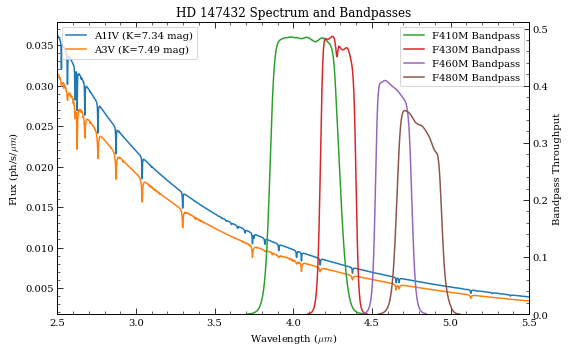

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']

xr = [2.5,5.5]

bp = pynrc.read_filter(*args_filter[-1])
kmags = [7.34, 7.49]
for i, sp in enumerate([sp1, sp2]):
    w = sp.wave / 1e4
    o = S.Observation(sp, bp, binset=bp.wave)
    sp.convert('photlam')
    f = sp.flux #/ sp.flux[(w>xr[0]) & (w<xr[1])].max()

    ind = (w>=xr[0]) & (w<=xr[1])
    ax.plot(w[ind], f[ind], label='{} (K={} mag)'.format(sp.name, kmags[i]))
    
ax.set_ylabel('Flux (ph/s/$\mu m$)')
ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength ($\mu m$)')
ax.set_title('{} Spectrum and Bandpasses'.format(name_sci))

# Overplot Filter Bandpass
ax2 = ax.twinx()
for i, af in enumerate(args_filter):
    bp = pynrc.read_filter(*af)
    ax2.plot(bp.wave/1e4, bp.throughput, color=cols[i+2], label=bp.name+' Bandpass')
ax2.set_ylim([0,ax2.get_ylim()[1]])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

fig.savefig(outdir+'{}_SED.pdf'.format(name_sci.replace(' ','')))

# Init an Observation (400x400)

In [255]:
apname = 'NRCB5_SUB400P'
fov_pix = int(apname[-4:-1]) + 1
oversample = 4

filt = 'F480M'
pupil = mask = None

nrc = pynrc.NIRCam(filter=filt, apname=apname, include_si_wfe=True,
                   fov_pix=fov_pix, oversample=oversample)


In [256]:
# Enable field-dependent WFE differences
nrc.wfe_field = True
nrc.wfe_drift = True

In [257]:
# Update detector settings and print sensitivities
# Total integration time will be multiplied by 8 (4 dithers x 2 rolls)
nrc.update_detectors(ngroup=10, nint=15, verbose=True)
_ = nrc.sensitivity(nsig=5, units='vegamag', verbose=True)

New Ramp Settings:
  read_mode  :    RAPID
  nf         :        1
  nd2        :        0
  ngroup     :       10
  nint       :       15
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      400
  ypix       :      400
  x0         :     1648
  y0         :        0
New Ramp Times
  t_group    :    1.656
  t_frame    :    1.656
  t_int      :   16.562
  t_int_tot1 :   18.239
  t_int_tot2 :   18.239
  t_exp      :  248.436
  t_acq      :  273.589
Point Source Sensitivity (5-sigma): 20.84 vegamag
Surface Brightness Sensitivity (5-sigma): 18.96 vegamag/arcsec^2


In [258]:
sp1 = pynrc.stellar_spectrum('M2V', 10, 'vegamag', bp_k)
sp2 = pynrc.stellar_spectrum('M2V',  10, 'vegamag', bp_k)


In [259]:
# Determine number of saturated pixels and saturation radius
sat_level = 0.9 # Well level considered to be saturated
im = nrc.saturation_levels(sp1, ngroup=10)
print('Pixels Saturated in core at ng=10: ', np.sum(im>sat_level))

im = nrc.saturation_levels(sp1, ngroup=2)
print('Pixels Saturated in core at ng=2 : ', np.sum(im>sat_level))

imrad = nrc_utils.dist_image(im, pixscale=nrc.pixelscale)
ind = im>sat_level
sat_rad = 0 if np.sum(ind)==0 else imrad[ind].max()
print('Pixel sauration to {:.2f} arcsec'.format(sat_rad))

Pixels Saturated in core at ng=10:  9
Pixels Saturated in core at ng=2 :  0
Pixel sauration to 0.00 arcsec


# Contrast Curve Variations (400x400)

## WFE Drift vs WFE Field

In [260]:
def do_contrast(im1, im2, header, nsig=5, supersample=True, func=np.std):

    data = im1 - im2
    
    pixscale = header['PIXELSCL']
    oversample = header['OVERSAMP']
    rr, stds = radial_std(data, pixscale=pixscale, oversample=oversample, supersample=supersample, func=func)

    imavg = (im1+im2)/2
    if supersample or oversample==1:
        psf_max = imavg.max()
    else:
        psf_max = frebin(imavg, scale=1/oversample).max()

    return rr, nsig*stds/psf_max


In [261]:
# WFE Field difference w.r.t center of array
x0, y0 = (1024,1024)

sep_asec = np.array([1,2,5,10,20,30])

xarr = np.ones([4,len(sep_asec)]) * x0
yarr = np.ones([4,len(sep_asec)]) * y0

xarr[0] -= sep_asec / nrc.pix_scale
xarr[1] += sep_asec / nrc.pix_scale

yarr[2] -= sep_asec / nrc.pix_scale
yarr[3] += sep_asec / nrc.pix_scale


In [262]:
# Nominal PSF
psf0, psf0_over = nrc.gen_psf(wfe_drift=0, coord_vals=(x0,y0), coord_frame='det', 
                              return_oversample=True)

# Field Dependent PSFs
psf_over_list = []
for i in trange(len(xarr.flatten())):
    xv, yv = (xarr.flatten()[i], yarr.flatten()[i])
    _, psf_over = nrc.gen_psf(wfe_drift=0, coord_vals=(xv,yv), coord_frame='det', 
                              return_oversample=True)
    psf_over_list.append(psf_over)
    
# WFE Drift PSFs
wfe_list = [1,2,5,10]
psf_over_list2 = []
for wfed in tqdm(wfe_list):
    _, psf_over = nrc.gen_psf(wfe_drift=wfed, coord_vals=(x0,y0), coord_frame='det', 
                              return_oversample=True)
    psf_over_list2.append(psf_over)

In [263]:
hdr = nrc._psf_coeff_hdr

# Field Contrasts
cont_arr = []
for im in psf_over_list:

    rr, cont = do_contrast(im, psf0_over, hdr, nsig=5, supersample=False, func=np.std)
    cont_arr.append(cont)

cont_arr = np.array(cont_arr).reshape([4,len(sep_asec),-1])
cont_med = np.mean(cont_arr, axis=0)


# WFE Drift Contrasts
cont_arr2 = []
for im in psf_over_list2:

    rr, cont = do_contrast(im, psf0_over, hdr, nsig=5, supersample=False, func=np.std)
    cont_arr2.append(cont)

cont_arr2 = np.array(cont_arr2)

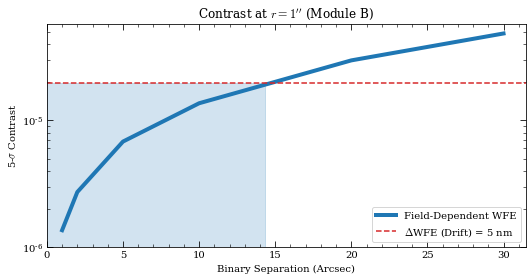

In [264]:
fig, ax = plt.subplots(1,1, figsize=(7.5,4))

vals = np.array([np.interp(1, rr, cont) for cont in cont_med])
ax.semilogy(sep_asec, vals, lw=4, label='Field-Dependent WFE')

xlim = [0,    ax.get_xlim()[1]]
ymin = 1e-6
ylim = [ymin, ax.get_ylim()[1]]

i = 2
cont = cont_arr2[i]
xvals = xlim
yvals = np.interp(1,rr,cont) * np.array([1,1])
label='$\Delta$WFE (Drift) = {} nm'.format(wfe_list[i])
ax.plot(xvals, yvals, label=label, ls='--', color='C3')

yv = yvals[0]
xv = np.interp(yv, vals, sep_asec) + 0.5
rect = matplotlib.patches.Rectangle((0,ymin), xv, yv-ymin, alpha=0.2, color='C0')

ax.add_patch(rect)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('Binary Separation (Arcsec)')
ax.set_ylabel('5-$\sigma$ Contrast')
ax.set_title('Contrast at $r=1^{\prime\prime}$' + f' (Module {nrc.module})')
ax.legend(loc='lower right')

fig.tight_layout()
#fig.savefig(outdir + 'contrast_compare.pdf')

## Contour Plots

In [109]:
filt = 'F480M'
nrc.filter = filt

nsig = 5

# Grid of mass and stellar separations
kmag_grid = np.arange(7,16,1)
sep_grid = np.arange(1,16,1)

# Radial distance to sample mass limit
sample_dist = 1.0

# get contour maps of magnitudes
mag_sens_grid = contrast_contour_map(nrc, sp1, sp2, nsig=nsig, sample_dist=sample_dist,
                                     kmag_grid=kmag_grid, sep_grid=sep_grid, std_func=robust.medabsdev)    

In [110]:
# Upper Sco, Beta Pic, and Columba Moving Groups
# names = ['Beta Pic', 'Columba', 'Upper Sco']
# dist_arr = [35, 50, 140] # pc
# age_arr  = [25, 40, 10] # Myr

names = [
    r'$\mathdefault{\beta}$ Pic Moving Group', 
    'Scorpious-Centaurus-Lupus']
dist_arr = [35, 140] # pc
age_arr  = [25, 10] # Myr


mass_grid_arr = []
for i in range(len(dist_arr)):
    dist_sci = dist_arr[i]
    age_sci = age_arr[i]

    mass_sens_grid = get_contrast_mass(nrc.filter, mag_sens_grid, dist_sci, age_sci)
    mass_grid_arr.append(mass_sens_grid)

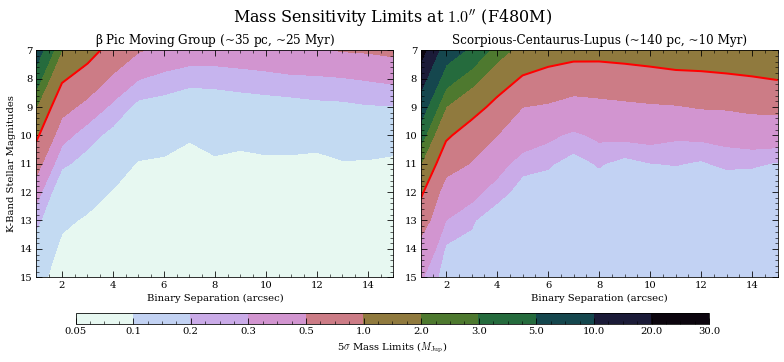

In [132]:
# Plot contours
fig, axes = plt.subplots(1,2, figsize=(11,5))

levels = np.array([0.05,0.1,0.2,0.3,0.5,1,2,3,5,10,20,30,])

for i, mass_sens_grid in enumerate(mass_grid_arr):
    
    if i==1:
        levels[2] = 0.25
    levels_log = np.log10(levels)    
    
    ax = axes[i]
    dist_sci = dist_arr[i]
    age_sci = age_arr[i]
    
    cs = plot_contours(ax, mass_sens_grid, sep_grid, kmag_grid, levels=levels, return_image=True)

    if i==0: 
        ax.set_ylabel('K-Band Stellar Magnitudes')
    else:
        ax.set_ylabel('')
    #str1 = f'{nrc.filter} Contrast limits at ' '0.5$\prime\prime$ '
    str2 = '~{:.0f} pc, ~{:.0f} Myr'.format(dist_sci, age_sci)
    ax.set_title(names[i] + f' ({str2})')

asec_str = "$^{\prime\prime}$"
title = 'Mass Sensitivity Limits at ${:.1f}${} ({})'.format(sample_dist, asec_str, nrc.filter)
fig.suptitle(title, fontsize=16)

# Add color bar
# [left, bottom, width, height]
cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.03]) 
cbar = plt.colorbar(cs, cax=cbaxes, orientation="horizontal", ticks=levels_log)
# Update labels to linear values
labels = ['{:.2f}'.format(x) if x==levels.min() else '{:.1f}'.format(x) for x in levels]
cbar.ax.set_xticklabels(labels)
cbar.set_label(f'{nsig}' + '$\sigma$ Mass Limits ($M_{\mathrm{Jup}}$)')

fig.tight_layout()
fig.subplots_adjust(bottom=0.23, top=0.86)

fig.savefig(outdir+'Mass_contours_sub400_{}_{:.1f}.pdf'.format(filt, sample_dist))

## Contrast Curves

In [100]:
nrc.filter = 'F480M'
nsig = 5

# Grid of mass and stellar separations
kmag_grid = np.arange(9,18)
# sep_grid = np.arange(1,5.5,0.5)
sep_grid = np.arange(2,11)

# Constant separation, but changing binary magnitudes
sky_sep = 5.0

rr_arr1 = []
mag_sens_arr1 = []
for kmag in tqdm(kmag_grid):
    sp1_renorm = sp1.renorm(kmag, 'vegamag', bp_k)
    sp2_renorm = sp2.renorm(kmag, 'vegamag', bp_k)
    _, diff, _ = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci,
                               sky_sep=sky_sep, center_lw=True, delta_roll=10)
    res = gen_contrast(nrc, diff, sp2_renorm, nsig=nsig, std_func=np.std)
    rr, contrast, mag_sens = res
    rr_arr1.append(rr)
    mag_sens_arr1.append(mag_sens)
    
rr_arr1 = np.array(rr_arr1)
mag_sens_arr1 = np.array(mag_sens_arr1)
    
# Constant binary magnitudes, but changing separation
kmag = 10

rr_arr2 = []
mag_sens_arr2 = []
sp1_renorm = sp1.renorm(kmag, 'vegamag', bp_k)
sp2_renorm = sp2.renorm(kmag, 'vegamag', bp_k)
for sky_sep in tqdm(sep_grid):
    _, diff, _ = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci,
                               sky_sep=sky_sep, center_lw=True, delta_roll=10)
    res = gen_contrast(nrc, diff, sp2_renorm, nsig=nsig, std_func=np.std)
    rr, contrast, mag_sens = res    
    rr_arr2.append(rr)
    mag_sens_arr2.append(mag_sens)
    
rr_arr2 = np.array(rr_arr2)
mag_sens_arr2 = np.array(mag_sens_arr2)


In [265]:
# Beta Pic Moving Group
name = 'BetaPic'
dist_sci = 35
age_sci = 25

# # Columba
# name = 'Columba'
# dist_sci = 50
# age_sci = 40

# # Upper Sco
# name = 'UpperSco'
# dist_sci = 140
# age_sci = 10

# Constant separation
mass_arr1 = get_contrast_mass(nrc.filter, mag_sens_arr1, dist_sci, age_sci)
# Different sized array for each contrast curve
mass_arr2 = get_contrast_mass(nrc.filter, mag_sens_arr2, dist_sci, age_sci)

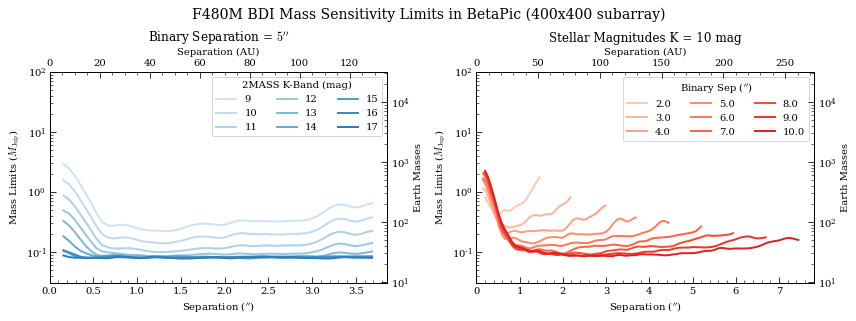

In [102]:
from pynrc.nb_funcs import plot_contrasts
fig, axes = plt.subplots(1,2,figsize=(12,4.5))

ax = axes[0]
ncurves = len(rr_arr1)
lin_vals = np.linspace(0.2,0.7,ncurves)
colors = plt.cm.Blues(lin_vals)
        
asec_str = "$^{\prime\prime}$"

yr = [0.03,100]

iwa = 206265*4.8e-6/6.5


for i in range(ncurves):
    rr = rr_arr1[i]
    mass_vals = mass_arr1[i]
    xvals = rr[rr>iwa]
    yvals = mass_vals[rr>iwa]
    
    label = "{:.0f}".format(kmag_grid[i])
    ax.semilogy(xvals, yvals, lw=2, color=colors[i], label=label)
ax.legend(ncol=3, title='2MASS K-Band (mag)', loc='upper right')
ax.set_title('Binary Separation = $5^{\prime\prime}$')

ax = axes[1]
ncurves = len(rr_arr2)
lin_vals = np.linspace(0.2,0.7,ncurves)
colors = plt.cm.Reds(lin_vals)

for i in range(ncurves):
    rr = rr_arr2[i]
    mass_vals = mass_arr2[i]
    xvals = rr[rr>iwa]
    yvals = mass_vals[rr>iwa]
    label = "{:.1f}".format(sep_grid[i])
    ax.semilogy(xvals, yvals, lw=2, color=colors[i], label=label)
ax.legend(ncol=3, title=f'Binary Sep ({asec_str})')
ax.set_title('Stellar Magnitudes K = 10 mag')

for i, ax in enumerate(axes):
    ax.set_xlim([0,ax.get_xlim()[1]])
    ax.set_ylim(yr)
    ax.xaxis.get_major_locator().set_params(nbins=10, steps=[1, 2, 5, 10])
    
    ylabel = 'Mass Limits ($M_{\mathrm{Jup}}$)'
    ax.set_ylabel(ylabel)
    ax.set_xlabel(f'Separation ({asec_str})')
    
    # Plot opposing axes in alternate units
    yr2 = np.array(ax.get_ylim()) * 318.0 # Convert to Earth masses
    ax2 = ax.twinx()
    ax2.set_yscale("log")
    ax2.set_ylim(yr2)
    ax2.set_ylabel('Earth Masses')
    
    ax3 = ax.twiny()
    xr3 = np.array(ax.get_xlim()) * dist_sci
    ax3.set_xlim(xr3)
    ax3.set_xlabel('Separation (AU)')

    ax3.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

    
# plot_contrasts(curves, nsig, wfe_list, obs=None, sat_rad=None, ax=None,
#     colors=None, xr=[0,10], yr=[25,5], return_axes=False)

fig.tight_layout()
fig.suptitle(f'{nrc.filter} BDI Mass Sensitivity Limits in {name} (400x400 subarray)', fontsize=14)
fig.subplots_adjust(top=0.78)

# fig.savefig(outdir + f'{name}_contrast_{nrc.filter}_sub400.pdf')

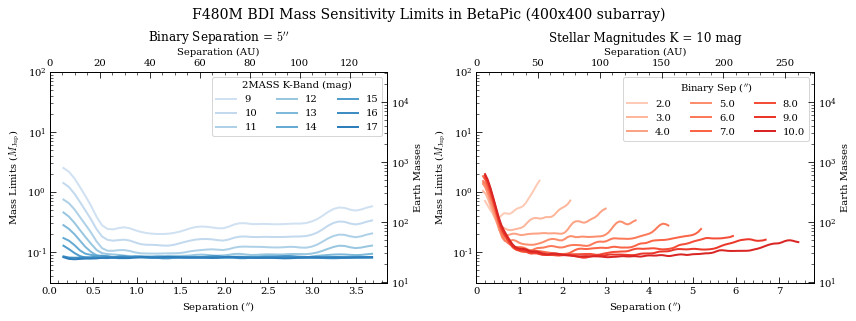

In [342]:
from pynrc.nb_funcs import plot_contrasts
fig, axes = plt.subplots(1,2,figsize=(12,4.5))

ax = axes[0]
ncurves = len(rr_arr1)
lin_vals = np.linspace(0.2,0.7,ncurves)
colors = plt.cm.Blues(lin_vals)
        
asec_str = "$^{\prime\prime}$"

yr = [0.03,100]

iwa = 206265*4.8e-6/6.5


for i in range(ncurves):
    rr = rr_arr1[i]
    mass_vals = mass_arr1[i]
    xvals = rr[rr>iwa]
    yvals = mass_vals[rr>iwa]
    
    label = "{:.0f}".format(kmag_grid[i])
    ax.semilogy(xvals, yvals, lw=2, color=colors[i], label=label)
ax.legend(ncol=3, title='2MASS K-Band (mag)', loc='upper right')
ax.set_title('Binary Separation = $5^{\prime\prime}$')

ax = axes[1]
ncurves = len(rr_arr2)
lin_vals = np.linspace(0.2,0.7,ncurves)
colors = plt.cm.Reds(lin_vals)

for i in range(ncurves):
    rr = rr_arr2[i]
    mass_vals = mass_arr2[i]
    xvals = rr[rr>iwa]
    yvals = mass_vals[rr>iwa]
    label = "{:.1f}".format(sep_grid[i])
    ax.semilogy(xvals, yvals, lw=2, color=colors[i], label=label)
ax.legend(ncol=3, title=f'Binary Sep ({asec_str})')
ax.set_title('Stellar Magnitudes K = 10 mag')

for i, ax in enumerate(axes):
    ax.set_xlim([0,ax.get_xlim()[1]])
    ax.set_ylim(yr)
    ax.xaxis.get_major_locator().set_params(nbins=10, steps=[1, 2, 5, 10])
    
    ylabel = 'Mass Limits ($M_{\mathrm{Jup}}$)'
    ax.set_ylabel(ylabel)
    ax.set_xlabel(f'Separation ({asec_str})')
    
    # Plot opposing axes in alternate units
    yr2 = np.array(ax.get_ylim()) * 318.0 # Convert to Earth masses
    ax2 = ax.twinx()
    ax2.set_yscale("log")
    ax2.set_ylim(yr2)
    ax2.set_ylabel('Earth Masses')
    
    ax3 = ax.twiny()
    xr3 = np.array(ax.get_xlim()) * dist_sci
    ax3.set_xlim(xr3)
    ax3.set_xlabel('Separation (AU)')

    ax3.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

    
# plot_contrasts(curves, nsig, wfe_list, obs=None, sat_rad=None, ax=None,
#     colors=None, xr=[0,10], yr=[25,5], return_axes=False)

fig.tight_layout()
fig.suptitle(f'{nrc.filter} BDI Mass Sensitivity Limits in {name} (400x400 subarray)', fontsize=14)
fig.subplots_adjust(top=0.78)

# fig.savefig(outdir + f'{name}_contrast_{nrc.filter}_sub400.pdf')

## Make an Image

In [333]:
#Beta Pic Moving Group
name = r'$\mathdefault{\beta}$ Pic Moving Group'
dist_sci = 35
age_sci = 25

#name_obj = "WDS 22407-4359"

In [391]:
sky_sep = 5
sky_pa = 45.

kmag1, kmag2 = (10, 10)
sp1_renorm = pynrc.stellar_spectrum('K8V', kmag1, 'vegamag', bp_k)
sp2_renorm = pynrc.stellar_spectrum('M1V', kmag2, 'vegamag', bp_k)

# 1. BDI with no rolls
kwargs = {
    'sky_sep' : sky_sep, 'sky_pa': sky_pa, 'delta_roll': 0, 'wfe_roll_drift': 0,
    'mass_pl': None, 'rth_pl': None, 'center_lw': False
}
res = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci, **kwargs)
im_slope, diff_bdi_noroll_avg, _ = res

# 2. BDI with roll averaging and roll subtraction
kwargs = {
    'sky_sep' : sky_sep, 'sky_pa': sky_pa, 'delta_roll': 10, 'wfe_roll_drift': 5,
    'mass_pl': None, 'rth_pl': None, 'center_lw': False
}
res = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci, **kwargs)
_, diff_bdi_roll_avg, diff_bdi_roll_sub = res

# 3. Roll subtraction only, no BDI
kwargs = {
    'sky_sep' : sky_sep, 'sky_pa': sky_pa, 'delta_roll': 10, 'wfe_roll_drift': 5,
    'mass_pl': None, 'rth_pl': None, 'center_lw': False
}
res = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci, no_bdi=True, **kwargs)
_, _, diff_roll_sub = res

# 4. Roll subtraction only, no BDI, single star
sp1_renorm = pynrc.stellar_spectrum('K8V', 35, 'vegamag', bp_k)
res = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci, no_bdi=True, **kwargs)
_, _, diff_roll_sub_single = res


In [397]:
func = robust.medabsdev

psf = nrc.gen_psf()
res = gen_contrast(nrc, diff_bdi_noroll_avg, sp2_renorm, nsig=5, std_func=func, psf=psf)
rr1, contrast1, sen_mag1 = res

res = gen_contrast(nrc, diff_bdi_roll_avg, sp2_renorm, nsig=5, std_func=func, psf=psf)
rr2, contrast2, sen_mag2 = res

res = gen_contrast(nrc, diff_bdi_roll_sub, sp2_renorm, nsig=5, std_func=func, psf=psf, roll_sub=True)
rr3, contrast3, sen_mag3 = res

res = gen_contrast(nrc, diff_roll_sub, sp2_renorm, nsig=5, std_func=func, psf=psf, roll_sub=True)
rr4, contrast4, sen_mag4 = res

res = gen_contrast(nrc, diff_roll_sub_single, sp2_renorm, nsig=5, std_func=func, psf=psf, roll_sub=True)
rr5, contrast5, sen_mag5 = res


Text(0, 0.5, 'Sensitivity (mags)')

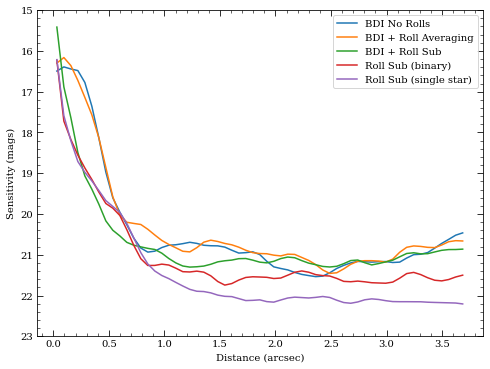

In [398]:
rr_all = [rr1, rr2, rr3, rr4, rr5]
sen_all = [sen_mag1, sen_mag2, sen_mag3, sen_mag4, sen_mag5]
titles = [
    'BDI No Rolls',  'BDI + Roll Averaging', 
    'BDI + Roll Sub', 'Roll Sub (binary)', 'Roll Sub (single star)'
]
for i, (rr, sen_mag) in enumerate(zip(rr_all, sen_all)):
    plt.plot(rr, sen_mag, label=titles[i])
    
plt.ylim([23,15])
plt.legend()

plt.xlabel("Distance (arcsec)")
plt.ylabel("Sensitivity (mags)")

In [394]:
sky_sep = 5
sky_pa = 45.

kmag1, kmag2 = (10, 10)
sp1_renorm = pynrc.stellar_spectrum('K8V', kmag1, 'vegamag', bp_k)
sp2_renorm = pynrc.stellar_spectrum('M1V', kmag2, 'vegamag', bp_k)

# Planet locations
rth_pl=[(0.5,-45),(1,45)]
# Masses (MJup)
mass_pl=[0.5,0.25]

# 1. BDI with no rolls
kwargs = {
    'sky_sep' : sky_sep, 'sky_pa': sky_pa, 'delta_roll': 0, 'wfe_roll_drift': 0,
    'mass_pl': mass_pl, 'rth_pl': rth_pl, 'center_lw': False
}
res = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci, **kwargs)
im_slope, diff_bdi_noroll_avg, _ = res

# 2. BDI with roll averaging and roll subtraction
kwargs = {
    'sky_sep' : sky_sep, 'sky_pa': sky_pa, 'delta_roll': 10, 'wfe_roll_drift': 5,
    'mass_pl': mass_pl, 'rth_pl': rth_pl, 'center_lw': False
}
res = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci, **kwargs)
_, diff_bdi_roll_avg, diff_bdi_roll_sub = res

# 3. Roll subtraction only, no BDI
kwargs = {
    'sky_sep' : sky_sep, 'sky_pa': sky_pa, 'delta_roll': 10, 'wfe_roll_drift': 5,
    'mass_pl': mass_pl, 'rth_pl': rth_pl, 'center_lw': False
}
res = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci, no_bdi=True, **kwargs)
_, _, diff_roll_sub = res

# 4. Roll subtraction only, no BDI, single star
sp1_renorm = pynrc.stellar_spectrum('K8V', 35, 'vegamag', bp_k)
res = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci, no_bdi=True, **kwargs)
_, _, diff_roll_sub_single = res


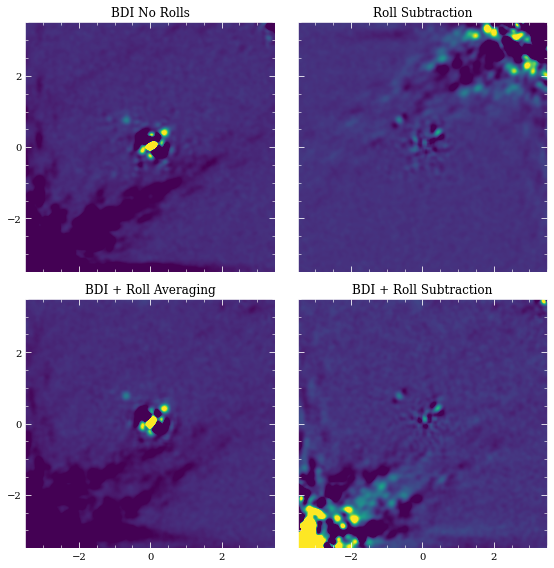

In [399]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharey=True, sharex=True)

imgs = [diff_bdi_noroll_avg, diff_roll_sub, diff_bdi_roll_avg, diff_bdi_roll_sub]
titles = ['BDI No Rolls', 'Roll Subtraction', 
          'BDI + Roll Averaging', 'BDI + Roll Subtraction']

for i, im in enumerate(imgs):
    ax = axes.flatten()[i]
    
    rdist = nrc_utils.dist_image(im, pixscale=nrc.pix_scale/oversample)

    ind = (rdist>0.5) & (rdist<3)
    mn = np.median(im[ind])
    std = np.std(im[ind])
    vmin = -0.05 #mn-5*std
    vmax =  0.3 #mn+20*std

    ypix, xpix = im.shape
    extent = np.array([-xpix,xpix,-ypix,ypix])/2 * (nrc.pix_scale / oversample) 

    ax.imshow(im, vmin=vmin, vmax=vmax, extent=extent, interpolation='bicubic')
    ax.set_title(titles[i])

    xylim = np.array([-1,1])*3.5
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
#     ax.set_xlabel('Arcsec')
#     ax.set_ylabel('Arcsec')

    ax.xaxis.get_major_locator().set_params(nbins=5, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=5, steps=[1, 2, 5, 10])

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')
    
fig.tight_layout()
# fig.savefig(outdir + 'rollavg_vs_rollsub.pdf')

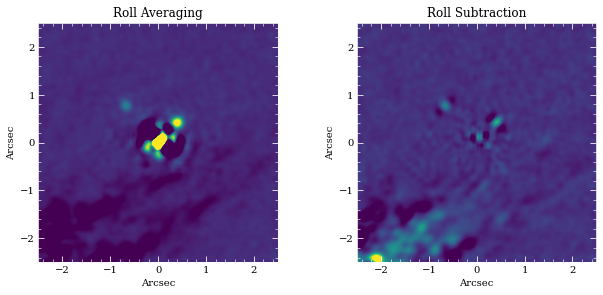

In [331]:
fig, axes = plt.subplots(1,2, figsize=(9,4.2))

im = diff #diff #- diff[::-1,::-1]
rdist = nrc_utils.dist_image(im, pixscale=nrc.pix_scale/oversample)
ind = (rdist>0.5) & (rdist<3)
mn = np.median(im[ind])
std = np.std(im[ind])
vmin = -0.05 #mn-5*std
vmax =  0.3 #mn+20*std

ypix, xpix = im.shape
extent = np.array([-xpix,xpix,-ypix,ypix])/2 * (nrc.pix_scale / oversample) 

axes[0].imshow(diff, vmin=vmin, vmax=vmax, extent=extent, interpolation='bicubic')
axes[0].set_title('Roll Averaging')
axes[1].imshow(diff_roll_sub, vmin=vmin, vmax=vmax, extent=extent, interpolation='bicubic')
axes[1].set_title('Roll Subtraction')

xylim = np.array([-1,1])*2.5
for ax in axes:
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')

    ax.xaxis.get_major_locator().set_params(nbins=5, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=5, steps=[1, 2, 5, 10])

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')
    
fig.tight_layout()
fig.savefig(outdir + 'rollavg_vs_rollsub.pdf')

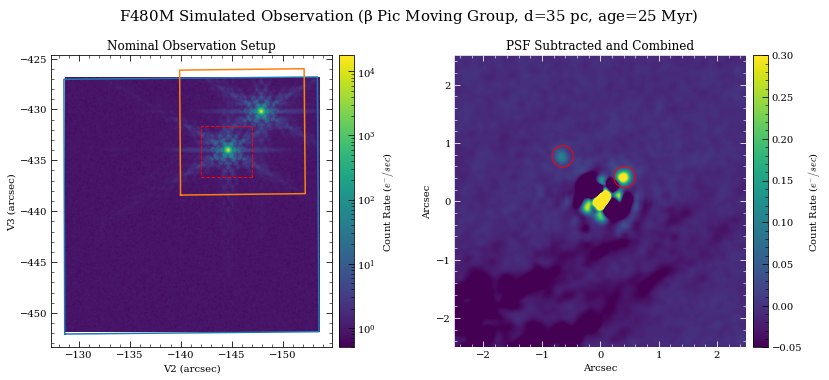

In [330]:
fig, axes = plt.subplots(1,2, figsize=(12,5.2))

ax = axes[0]

ap_lw = siaf_nrc['NRCB5_SUB400P']
ap_sw = siaf_nrc['NRCB1_SUB400P']

ap_lw.plot(ax=ax, fill=False, label=False, mark_ref=False)
ap_sw.plot(ax=ax, fill=False, label=False)

yr = ax.get_ylim()
xr = ax.get_xlim()

v2_corn, v3_corn = ap_lw.corners('tel')
extent = [v2_corn[0], v2_corn[1], v3_corn[1], v3_corn[2]]
# vmin = 0
# vmax = 5*np.std(im_slope)
norm = matplotlib.colors.LogNorm(vmin=0.5, vmax=im_slope.max())
image = ax.imshow(im_slope, extent=extent, norm=norm, interpolation='bicubic')

# Add color bar
cbar = fig.colorbar(image, ax=ax, pad=0.02, label='Count Rate ($e^{-}/sec$)')


ax.set_xlim(xr)
ax.set_ylim(yr)
ax.set_title("Nominal Observation Setup")


# Second Axes
ax = axes[1]

im = diff
rdist = nrc_utils.dist_image(im, pixscale=nrc.pix_scale/oversample)
ind = (rdist>0.5) & (rdist<3)
mn = np.median(im[ind])
std = np.std(im[ind])
vmin = -0.05 #mn-5*std
vmax =  0.3 #mn+20*std

ypix, xpix = im.shape
extent = np.array([-xpix,xpix,-ypix,ypix])/2 * (nrc.pix_scale / oversample) 
image = ax.imshow(im, vmin=vmin, vmax=vmax, extent=extent, interpolation='bicubic')
# xylim = np.array([-1,1]) * sky_sep * np.sqrt(2) / 2
xylim = np.array([-1,1])*2.5
ax.set_xlim(xylim)
ax.set_ylim(xylim)

# Circle planets
for r, th in rth_pl:
    rpix = r / nrc.pix_scale
    x_pl, y_pl = nrc_utils.rtheta_to_xy(rpix,th)
    loc = np.array([x_pl+1, y_pl+1]) * nrc.pix_scale
    radius = 1.2 * 206265*4.8e-6/6.5
    circle = matplotlib.patches.Circle(loc, radius=radius, lw=1, edgecolor='red', facecolor='none')
    ax.add_artist(circle)

# Add color bar
cbar = fig.colorbar(image, ax=ax, pad=0.02, label='Count Rate ($e^{-}/sec$)')

# Add to rectangular image to first axes
xs = ax.get_xlim()[1] - ax.get_xlim()[0] #xpix * (nrc.pix_scale / oversample) 
ys = ax.get_ylim()[1] - ax.get_ylim()[0] #ypix * (nrc.pix_scale / oversample)
# Location around refernece point assuming a size of xs x ys
loc = np.array(ap_lw.reference_point('tel')) - np.array([xs/2,ys/2])
# Shift to center on 2nd star
xoff, yoff = nrc_utils.rtheta_to_xy(sky_sep/2, sky_pa-5) # Subtract 5deg for first roll angle
loc -= (xoff,yoff)
rect = matplotlib.patches.Rectangle(loc, xs,ys, edgecolor='red', facecolor='none', ls='--')
axes[0].add_artist(rect)


ax.set_title("PSF Subtracted and Combined")
ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')

ax.tick_params(axis='both', color='white', which='both')
for k in ax.spines.keys():
    ax.spines[k].set_color('white')

title = "{} Simulated Observation ({}, d={:.0f} pc, age={:.0f} Myr)"\
        .format(nrc.filter, name, dist_sci, age_sci)
fig.suptitle(title, fontsize=15)

fig.tight_layout()
fig.subplots_adjust(top=0.85)

fig.savefig(outdir + f'simulated_obs_{nrc.filter}.pdf')

In [13]:
apname = 'NRCB5_SUB160P'
fov_pix = int(apname[-4:-1]) + 1
oversample = 4

filt = 'F480M'
pupil = mask = None

nrc = pynrc.NIRCam(filter=filt, apname=apname, include_si_wfe=True,
                   fov_pix=fov_pix, oversample=oversample)


In [14]:
# Enable field-dependent WFE differences
nrc.wfe_field = True

In [15]:
# Allow PSFs to saturate and determine best setup to maximize SNR of faint source
sp_faint  = pynrc.stellar_spectrum('M5V', 20, 'vegamag', bp_k)
sp_bright = sp1
res = nrc.ramp_optimize(sp_faint, sp_bright=sp_bright, well_frac_max=10, tacq_max=450, 
                        patterns='RAPID', verbose=True)

RAPID
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10  144      2.79    401.24    442.11      7.4    6.967    0.354
RAPID        10  145      2.79    404.03    445.18      7.5    6.967    0.354
RAPID        10  146      2.79    406.81    448.25      7.5    6.967    0.354
RAPID        10  147      2.79    409.60    451.32      7.5    6.967    0.354
RAPID        10  148      2.79    412.39    454.39      7.6    6.967    0.354


In [16]:
# Update detector settings and print sensitivities
nrc.update_detectors(ngroup=10, nint=80, verbose=True)
_ = nrc.sensitivity(nsig=5, units='vegamag', verbose=True)

New Ramp Settings:
  read_mode  :    RAPID
  nf         :        1
  nd2        :        0
  ngroup     :       10
  nint       :       80
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      160
  ypix       :      160
  x0         :     1888
  y0         :        0
New Ramp Times
  t_group    :    0.279
  t_frame    :    0.279
  t_int      :    2.786
  t_int_tot1 :    3.070
  t_int_tot2 :    3.070
  t_exp      :  222.912
  t_acq      :  245.616
Point Source Sensitivity (5-sigma): 19.88 vegamag
Surface Brightness Sensitivity (5-sigma): 17.99 vegamag/arcsec^2


In [17]:
# Determine number of saturated pixels and saturation radius
sat_level = 0.9 # Well level considered to be saturated
im = nrc.saturation_levels(sp1, ngroup=10)
print('Pixels Saturated in core at ng=10: ', np.sum(im>sat_level))

im = nrc.saturation_levels(sp1, ngroup=2)
print('Pixels Saturated in core at ng=2 : ', np.sum(im>sat_level))

imrad = nrc_utils.dist_image(im, pixscale=nrc.pixelscale)
sat_rad = imrad[im>sat_level].max()
print('Pixel sauration to {:.2f} arcsec'.format(sat_rad))

Pixels Saturated in core at ng=10:  13
Pixels Saturated in core at ng=2 :  5
Pixel sauration to 0.10 arcsec


## Contrast Curve Variations (160x160)

In [45]:
#Beta Pic Moving Group
name = 'BetaPic'
dist_sci = 35
age_sci = 25

# Columba
# name = 'Columba'
# dist_sci = 50
# age_sci = 40

# Upper Sco
# name = 'UpperSco'
# dist_sci = 140
# age_sci = 10

nsig = 5

In [46]:
nrc.filter='F480M'

# Grid of mass and stellar separations
kmag_grid = np.arange(7,16)
sep_grid = np.arange(1,5.5,0.5)

# Constant separation, but changing binary magnitudes
sky_sep = 3.0

rr_arr1 = []
mag_sens_arr1 = []
for kmag in tqdm(kmag_grid):
    sp1_renorm = sp1.renorm(kmag, 'vegamag', bp_k)
    sp2_renorm = sp2.renorm(kmag, 'vegamag', bp_k)
#     im_slope, diff = gen_image(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci,
#                                sky_sep=sky_sep, center_lw=True)
    _, diff, _ = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci,
                               sky_sep=sky_sep, center_lw=True, delta_roll=10)
    res = gen_contrast(nrc, diff, sp2_renorm, nsig=nsig)
    rr, contrast, mag_sens = res
    rr_arr1.append(rr)
    mag_sens_arr1.append(mag_sens)
    
rr_arr1 = np.array(rr_arr1)
mag_sens_arr1 = np.array(mag_sens_arr1)
    
# Constant binary magnitudes, but changing separation
kmag = 10

rr_arr2 = []
mag_sens_arr2 = []
sp1_renorm = sp1.renorm(kmag, 'vegamag', bp_k)
sp2_renorm = sp2.renorm(kmag, 'vegamag', bp_k)
for sky_sep in tqdm(sep_grid):
#     im_slope, diff = gen_image(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci,
#                                sky_sep=sky_sep, center_lw=True)
    _, diff, _ = gen_roll_diff(nrc, sp1_renorm, sp2_renorm, age_sci, dist_sci,
                               sky_sep=sky_sep, center_lw=True, delta_roll=10)
    res = gen_contrast(nrc, diff, sp2_renorm, nsig=nsig)
    rr, contrast, mag_sens = res    
    rr_arr2.append(rr)
    mag_sens_arr2.append(mag_sens)
    
rr_arr2 = np.array(rr_arr2)
mag_sens_arr2 = np.array(mag_sens_arr2)


In [47]:
# Constant separation
mass_arr1 = get_contrast_mass(nrc.filter, mag_sens_arr1, dist_sci, age_sci)
# Different sized array for each contrast curve
mass_arr2 = get_contrast_mass(nrc.filter, mag_sens_arr2, dist_sci, age_sci)

In [238]:
# Convert from magnitudes to mass based on age, distance, and models



# Read in Linder models
tbl = nrc_utils.linder_table()
mass_mjup, mag_vals = nrc_utils.linder_filter(tbl, nrc.filter, age_sci, dist=dist_sci)
# Sort by mags
isort = np.argsort(mag_vals)
mass_mjup = mass_mjup[isort]
mag_vals = mag_vals[isort]

# Constant separation
mass_arr1 = np.interp(mag_sens_arr1, mag_vals, mass_mjup)

# Different sized array for each contrast curve
mass_arr2 = [np.interp(mag_sens, mag_vals, mass_mjup) for mag_sens in mag_sens_arr2]

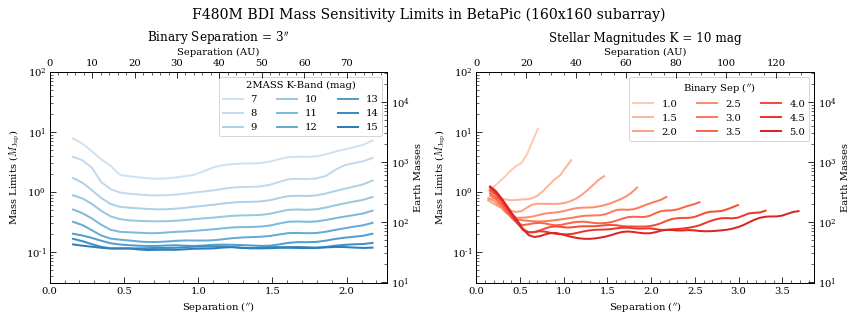

In [49]:
from pynrc.nb_funcs import plot_contrasts
fig, axes = plt.subplots(1,2,figsize=(12,4.5))

ax = axes[0]
ncurves = len(rr_arr1)
lin_vals = np.linspace(0.2,0.7,ncurves)
colors = plt.cm.Blues(lin_vals)
        
asec_str = "$^{\prime\prime}$"

yr = [0.03,100]

    
for i in range(ncurves):
    rr = rr_arr1[i]
    mass_vals = mass_arr1[i]
    xvals = rr[rr>sat_rad]
    yvals = mass_vals[rr>sat_rad]
    
    label = "{:.0f}".format(kmag_grid[i])
    ax.semilogy(xvals, yvals, lw=2, color=colors[i], label=label)
ax.legend(ncol=3, title='2MASS K-Band (mag)', loc='upper right')
ax.set_title(f'Binary Separation = 3{asec_str}')

ax = axes[1]
ncurves = len(rr_arr2)
lin_vals = np.linspace(0.2,0.7,ncurves)
colors = plt.cm.Reds(lin_vals)

for i in range(ncurves):
    rr = rr_arr2[i]
    mass_vals = mass_arr2[i]
    xvals = rr[rr>sat_rad]
    yvals = mass_vals[rr>sat_rad]
    label = "{:.1f}".format(sep_grid[i])
    ax.semilogy(xvals, yvals, lw=2, color=colors[i], label=label)
ax.legend(ncol=3, title=f'Binary Sep ({asec_str})')
ax.set_title('Stellar Magnitudes K = 10 mag')

for i, ax in enumerate(axes):
    ax.set_xlim([0,ax.get_xlim()[1]])
    ax.set_ylim(yr)
    ax.xaxis.get_major_locator().set_params(nbins=10, steps=[1, 2, 5, 10])
    
    ylabel = 'Mass Limits ($M_{\mathrm{Jup}}$)'
    ax.set_ylabel(ylabel)
    ax.set_xlabel(f'Separation ({asec_str})')
    
    # Plot opposing axes in alternate units
    yr2 = np.array(ax.get_ylim()) * 318.0 # Convert to Earth masses
    ax2 = ax.twinx()
    ax2.set_yscale("log")
    ax2.set_ylim(yr2)
    ax2.set_ylabel('Earth Masses')
    
    ax3 = ax.twiny()
    xr3 = np.array(ax.get_xlim()) * dist_sci
    ax3.set_xlim(xr3)
    ax3.set_xlabel('Separation (AU)')

    ax3.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

    
# plot_contrasts(curves, nsig, wfe_list, obs=None, sat_rad=None, ax=None,
#     colors=None, xr=[0,10], yr=[25,5], return_axes=False)

fig.tight_layout()
fig.suptitle(f'{nrc.filter} BDI Mass Sensitivity Limits in {name} (160x160 subarray)', fontsize=14)
fig.subplots_adjust(top=0.78)

fig.savefig(outdir + f'{name}_contrast_{nrc.filter}_sub160.pdf')

## Plot contours for Three Moving Groups/Associations

### F480M filter

In [51]:
# Upper Sco, Beta Pic, and Columba Moving Groups
names = ['Beta Pic', 'Columba', 'Upper Sco']
dist_arr = [35, 50, 140] # pc
age_arr  = [25, 40, 10] # Myr

# Grid of mass and stellar separations
kmag_grid = np.arange(7,16)
sep_grid = np.arange(1,5.5,0.5)

# Radial distance to sample mass limit
sample_dist = 0.5

filt = 'F480M'
nrc.filter = filt

mass_grid_arr = []
for i in trange(len(dist_arr)):
    dist_sci = dist_arr[i]
    age_sci = age_arr[i]
    
    # Only need to generate single magnitude grid, then convert to masses 
    if i==0:
        mag_sens_grid = contrast_contour_map(nrc, dist_sci, age_sci, sp1, sp2, nsig=nsig, 
                                                kmag_grid=kmag_grid, sep_grid=sep_grid, 
                                                sample_dist=sample_dist, return_mags=True)
    mass_sens_grid = get_contrast_mass(nrc.filter, mag_sens_grid, dist_sci, age_sci)
    mass_grid_arr.append(mass_sens_grid)

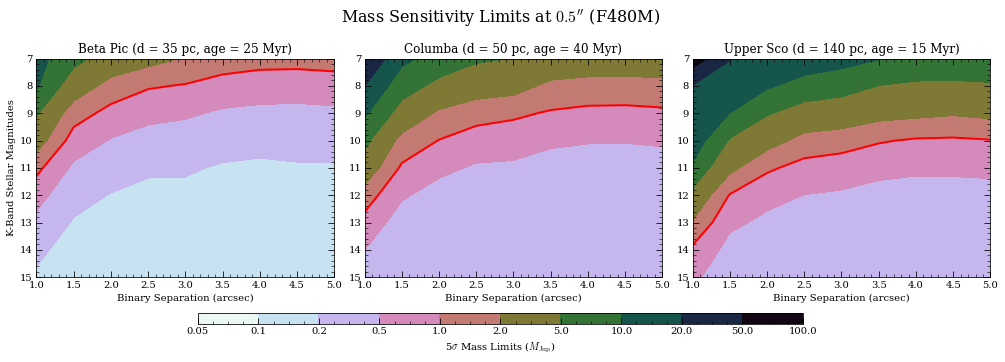

In [60]:
# Plot contours
fig, axes = plt.subplots(1,3, figsize=(14,5))
 
levels = np.array([0.05,0.1,0.2,0.5,1,2,5,10,20,50,100])
levels_log = np.log10(levels)    

for i, mass_sens_grid in enumerate(mass_grid_arr):
    ax = axes[i]
    dist_sci = dist_arr[i]
    age_sci = age_arr[i]
    
    cs = plot_contours(ax, mass_sens_grid, sep_grid, kmag_grid, levels=levels, return_image=True)

    if i==0: 
        ax.set_ylabel('K-Band Stellar Magnitudes')
    else:
        ax.set_ylabel('')
    #str1 = f'{nrc.filter} Contrast limits at ' '0.5$\prime\prime$ '
    str2 = 'd = {:.0f} pc, age = {:.0f} Myr'.format(dist_sci, age_sci)
    ax.set_title(f'{names[i]} ({str2})')

asec_str = "$^{\prime\prime}$"
title = 'Mass Sensitivity Limits at ${:.1f}${} ({})'.format(sample_dist, asec_str, nrc.filter)
fig.suptitle(title, fontsize=16)

# Add color bar
# [left, bottom, width, height]
cbaxes = fig.add_axes([0.2, 0.1, 0.6, 0.03]) 
cbar = plt.colorbar(cs, cax=cbaxes, orientation="horizontal", ticks=levels_log)
# Update labels to linear values
labels = ['{:.2f}'.format(x) if x==levels.min() else '{:.1f}'.format(x) for x in levels]
cbar.ax.set_xticklabels(labels)
cbar.set_label(f'{nsig}' + '$\sigma$ Mass Limits ($M_{\mathrm{Jup}}$)')

fig.tight_layout()
fig.subplots_adjust(bottom=0.23)

fig.savefig(outdir+'Mass_contours_sub160_{}_.pdf'.format(filt))

### Beta Pic Moving Group

In [206]:
nsig = 5

#Beta Pic Moving Group
name = 'BetaPic'
dist_sci = 35
age_sci = 25

mass_grid_betapic = {}
for filt in tqdm(['F410M', 'F430M', 'F460M', 'F480M']):

    nrc.filter = filt
    mass_grid_betapic[filt] = contrast_contour_map(nrc, dist_sci, age_sci, sp1, sp2)


In [ ]:
# Plot contours for each filter
d = mass_grid_betapic

kmag_grid = np.arange(7,16)
sep_grid = np.arange(1,5.5,0.5)

# Location at which to sample mass limit
sample_dist = 0.5

for filt in d.keys():
    
    mass_sens_grid = d[filt]

    # Plot contours
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    
    plot_contours(ax, mass_sens_grid, sep_grid, kmag_grid, add_color_bar=True)

    asec_str = "$^{\prime\prime}$"
    str1 = '{} Mass limits at {:0.1f}{} '.format(filt, sample_dist, asec_str)
    str2 = '({}, d={:.0f} pc, age={:.0f} Myr)'.format(name, dist_sci, age_sci)
    ax.set_title(str1 + str2)

    fig.tight_layout()
    fig.savefig(outdir+'{}_contours_{}.pdf'.format(name,filt))

### Upper Sco

In [ ]:
nsig = 5

# Upper Sco
name = 'UpperSco'
dist_sci = 140
age_sci = 10

mass_grid_uppsco = {}
for filt in tqdm(['F410M', 'F430M', 'F460M', 'F480M']):

    nrc.filter = filt
    mass_grid_uppsco[filt] = contrast_contour_map(nrc, dist_sci, age_sci, sp1, sp2)


In [ ]:
# Plot contours for each filter
d = mass_grid_uppsco

kmag_grid = np.arange(7,16)
sep_grid = np.arange(1,5.5,0.5)

# Location at which to sample mass limit
sample_dist = 0.5

for filt in d.keys():
    
    mass_sens_grid = d[filt]

    # Plot contours
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    
    plot_contours(ax, mass_sens_grid, sep_grid, kmag_grid, add_color_bar=True)

    asec_str = "$^{\prime\prime}$"
    str1 = '{} Mass limits at {:0.1f}{} '.format(filt, sample_dist, asec_str)
    str2 = '({}, d={:.0f} pc, age={:.0f} Myr)'.format(name, dist_sci, age_sci)
    ax.set_title(str1 + str2)

    fig.tight_layout()
    fig.savefig(outdir+'{}_contours_{}.pdf'.format(name,filt))

### Columba Association

In [ ]:
nsig = 5

# Columba
name = 'Columba'
dist_sci = 50
age_sci = 40

mass_grid_columba = {}
for filt in tqdm(['F410M', 'F430M', 'F460M', 'F480M']):

    nrc.filter = filt
    mass_grid_columba[filt] = contrast_contour_map(nrc, dist_sci, age_sci, sp1, sp2)


In [ ]:
# Plot contours for each filter
d = mass_grid_columba

kmag_grid = np.arange(7,16)
sep_grid = np.arange(1,5.5,0.5)

# Location at which to sample mass limit
sample_dist = 0.5

for filt in d.keys():
    
    mass_sens_grid = d[filt]

    # Plot contours
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    
    plot_contours(ax, mass_sens_grid, sep_grid, kmag_grid, add_color_bar=True)

    asec_str = "$^{\prime\prime}$"
    str1 = '{} Mass limits at {:0.1f}{} '.format(filt, sample_dist, asec_str)
    str2 = '({}, d={:.0f} pc, age={:.0f} Myr)'.format(name, dist_sci, age_sci)
    ax.set_title(str1 + str2)

    fig.tight_layout()
    fig.savefig(outdir+'{}_contours_{}.pdf'.format(name,filt))

In [726]:
# imcut1 = pad_or_cut_to_size(im1_crop_over, 20)
# imcut2 = pad_or_cut_to_size(im2_crop_over, 20)
# scl = scale_ref_image(imcut2, imcut1)
# diff = optimal_difference(im2_crop_over, im1_crop_over, scl, binsize=1, center=None, 
#                           mask_good=None, sub_mean=True, std_func=robust.std)

# print(scl)



print(scl)

0.8707426404162173


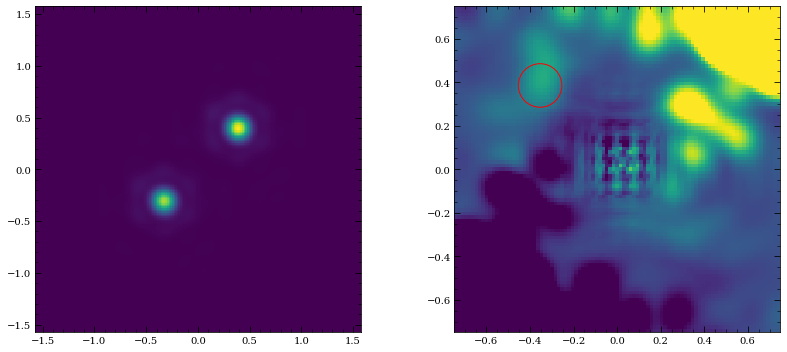

In [735]:
fig, axes = plt.subplots(1,2,figsize=(12,5))

ax = axes[0]
im = im_crop_over
pscale = nrc.pix_scale / oversample

extent = 0.5 * np.array([-1,1,-1,1]) * im.shape[0] * pscale
ax.imshow(im, extent=extent)


ax = axes[1]
im = diff
pscale = nrc.pix_scale / oversample

mn = np.median(im)
std = robust.std(im)

vmin = mn - 1*std
vmax = mn + 3*std

extent = 0.5 * np.array([-1,1,-1,1]) * im.shape[0] * pscale
ax.imshow(im, extent=extent, vmin=vmin, vmax=vmax)

loc = np.array([x_pl, y_pl+0.5])*nrc.pix_scale
circle = matplotlib.patches.Circle(loc, radius=1/10., lw=1, edgecolor='red', facecolor='none')
ax.add_artist(circle);

fig.tight_layout()

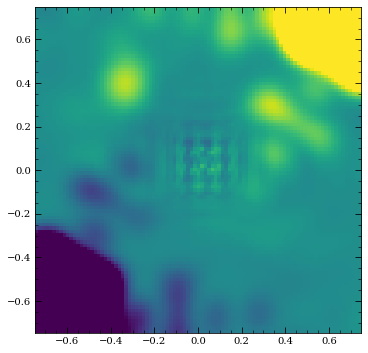

In [660]:
mn = np.median(diff)
std = robust.std(diff)

vmin = mn - 5*std
vmax = mn + 5*std

extent = 0.5 * np.array([-1,1,-1,1]) * npix_osamp * nrc.pix_scale / oversample
plt.imshow(diff, extent=extent, vmin=vmin, vmax=vmax)

In [129]:
# Create detector image
im1_over = nrc_utils.fshift(psf1_over, xsh1_over, ysh1_over, pad=True)
im2_over = nrc_utils.fshift(psf2_over, xsh2_over, ysh2_over, pad=True)

im_over = nrc_utils.pad_or_cut_to_size(im1_over + im2_over, nx*oversample)
# Rebin to detector pixels
im_slope = nrc_utils.frebin(im_over, scale=1/oversample)

In [162]:
# Crop around sci reference point
xref, yref = siaf_ap.reference_point('sci')
xsh, ysh = (int(nx/2 - xref), int(ny/2 - yref))
nxy_new = np.min([2*int(nx-xref), 2*int(ny-yref)])
im_crop = nrc_utils.pad_or_cut_to_size(im_slope,(nxy_new,nxy_new),offset_vals=(ysh,xsh))

In [164]:
det = nrc.Detectors[0]

In [165]:
im_crop_noise = det.pixel_noise(fsrc=im_crop)

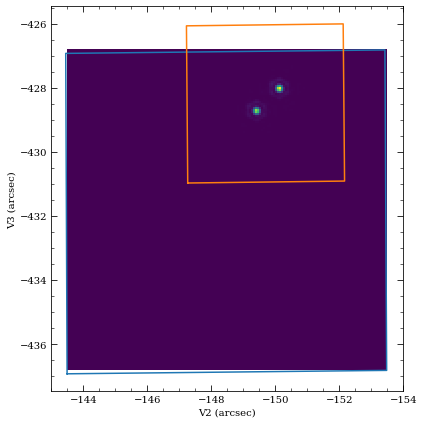

In [146]:
fig, ax = plt.subplots(1,1)
# ax.imshow(im_slope)

ap_lw = siaf_nrc['NRCB5_SUB160P']
ap_sw = siaf_nrc['NRCB1_SUB160P']

v2_corn, v3_corn = ap_lw.corners('tel')
extent = [v2_corn[0], v2_corn[1], v3_corn[1], v3_corn[2]]
ax.imshow(im_slope, extent=extent)

ap_lw.plot(ax=ax, fill=False)
ap_sw.plot(ax=ax, fill=False)

ax.set_xlim([-143,-154])

fig.tight_layout()

In [110]:
xcen = ycen = int(161/2)
psf2[ycen-1:ycen+2, ycen-1:ycen+2]

array([[ 75974.88567385, 116342.40696453,  78239.71216318],
       [114341.08869797, 168348.57967409, 114509.45031819],
       [ 77621.3375118 , 115380.18835001,  75813.28013826]])

In [109]:
psf2[ycen,xcen]

168348.5796740874

In [108]:
psf2.max()

168348.5796740874

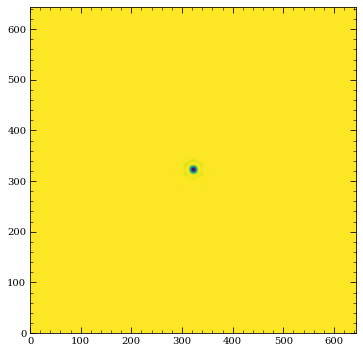

In [96]:
plt.imshow(psf2_over-psf1_over)

In [61]:
coords2_v2v3

array([-149.33727061, -428.81804739])

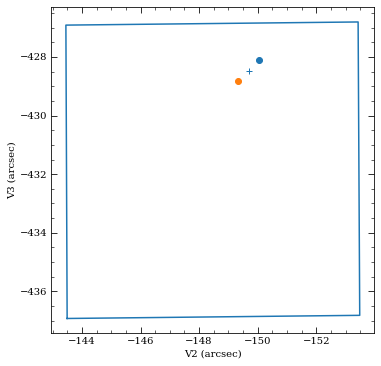

In [86]:
fig, ax = plt.subplots(1,1)
nrc.siaf_ap.plot('tel', mark_ref=True, ax=ax, fill=False)
ax.scatter(coords1_v2v3[0], coords1_v2v3[1])
ax.scatter(coords2_v2v3[0], coords2_v2v3[1])

In [68]:
v2v3_to_pixel(nrc.siaf_ap.AperName, coords0_v2v3[0], coords0_v2v3[1], frame='sci')

(100.49329957763669, 134.6902101855066)

In [66]:
v2v3_to_pixel(nrc.siaf_ap.AperName, coords1_v2v3[0], coords1_v2v3[1], frame='sci')

(106.19037143306645, 140.27898583168584)

In [67]:
v2v3_to_pixel(nrc.siaf_ap.AperName, coords2_v2v3[0], coords2_v2v3[1], frame='sci')

(94.79624743501864, 129.1010034828204)

In [10]:
v2_arr = np.array([-146.055848,-146.055848])
v3_arr = np.array([-432.184174,-431.184174])
%time psfs = nrc.gen_psf(coord_vals=(v2_arr,v3_arr), coord_frame='tel')

CPU times: user 3.74 s, sys: 1.25 s, total: 4.99 s
Wall time: 3.21 s


In [15]:
np.allclose(psf2, psfs[0])

False

In [17]:
cf_fit = nrc._psf_coeff_mod['si_field'] 
v2grid  = nrc._psf_coeff_mod['si_field_v2grid'] 
v3grid  = nrc._psf_coeff_mod['si_field_v3grid'] 


In [29]:
from pynrc.psfs import field_coeff_func
cf_mod = field_coeff_func(v2grid, v3grid, cf_fit, v2_arr, v3_arr)

In [30]:
cf_mod.shape

(2, 10, 516, 516)

In [24]:
nrc._psf_coeff.shape

(10, 1604, 1604)

In [31]:
new_shape = psf_coeff.shape[1:]

In [33]:
new_shape

(1604, 1604)

In [25]:
psf_coeff     = nrc._psf_coeff
psf_cf_dim = len(psf_coeff.shape)

In [26]:
cf_mod.shape[-psf_cf_dim:]

(10, 516, 516)

In [34]:
cf_mod_resize = np.array([nrc_utils.pad_or_cut_to_size(im, new_shape) for im in cf_mod])

In [37]:
psf_coeff_mod = 0
psf_coeff_mod += cf_mod_resize

In [39]:
test = psf_coeff + psf_coeff_mod

In [40]:
test.shape

(2, 10, 1604, 1604)

In [8]:
psf0 = nrc.gen_psf()

In [63]:
from copy import deepcopy
kwargs = deepcopy(nrc.psf_info)
kwargs['pupil'] = nrc.pupil
kwargs.pop('save', None)
kwargs.pop('force', None)
kwargs.pop('include_si_wfe', None)
kwargs.pop('offset_r', None)
kwargs.pop('offset_theta', None)

0

In [64]:
kwargs

{'fov_pix': 401,
 'oversample': 4,
 'tel_pupil': None,
 'opd': ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0),
 'jitter': 'gaussian',
 'jitter_sigma': 0.007,
 'pupil': 'CLEAR'}

In [10]:
cf_resid = nrc_utils.field_coeff(nrc.filter, nrc.psf_coeff, module=nrc.module, **kwargs)

In [11]:
ap = nrc.siaf_ap
v2, v3 = ap.convert(200, 200, 'sci', 'tel')  # arcsec

sep_arr = np.array([0,2,4,6])
v2_asec = np.ones(sep_arr.shape) + v2
v3_asec = np.array([v3+sep for sep in sep_arr])

In [12]:
%time cf_new_all = nrc.psf_coeff + nrc_utils.field_model(v2_asec/60, v3_asec/60, cf_resid)

CPU times: user 4.56 s, sys: 876 ms, total: 5.44 s
Wall time: 1.71 s


In [13]:
psf_all = []
for cf_new in cf_new_all:
    psf = nrc_utils.gen_image_coeff(nrc.filter, pupil=nrc.pupil, mask=nrc.mask, module=nrc.module, 
                                    coeff=cf_new, fov_pix=fov_pix, oversample=oversample)
    psf_all.append(psf)

~7th mag primary, with a K=[7,8,9] mag secondary at [2”, 4”, and 6”]

A5 primary, with an A5, G0 and K5 companion

F212N and F405N

F210M / F410M

F200W / F444W

In [35]:
bp_k = nrc_utils.bp_2mass('k')

sp_A5 = pynrc.stellar_spectrum('A5V', 7, 'vegamag', bp_k)
sp_G0 = pynrc.stellar_spectrum('A5V', 8, 'vegamag', bp_k)
sp_K5 = pynrc.stellar_spectrum('A5V', 9, 'vegamag', bp_k)

In [36]:
from pynrc.nrc_utils import gen_image_coeff

In [37]:
psf0 = gen_image_coeff(nrc.filter, pupil=nrc.pupil, mask=nrc.mask, module=nrc.module, sp_norm=sp_A5,
                       coeff=cf_new_all[0], fov_pix=fov_pix, oversample=oversample)

In [40]:
psfs_A5 = []
for cf_new in cf_new_all:
    psf = gen_image_coeff(nrc.filter, pupil=nrc.pupil, mask=nrc.mask, module=nrc.module, sp_norm=sp_A5, 
                          coeff=cf_new, fov_pix=fov_pix, oversample=oversample)
    psfs_A5.append(psf)

In [41]:
psfs_G0 = []
for cf_new in cf_new_all:
    psf = gen_image_coeff(nrc.filter, pupil=nrc.pupil, mask=nrc.mask, module=nrc.module, sp_norm=sp_G0, 
                          coeff=cf_new, fov_pix=fov_pix, oversample=oversample)
    psfs_G0.append(psf)

In [42]:
psfs_K5 = []
for cf_new in cf_new_all:
    psf = gen_image_coeff(nrc.filter, pupil=nrc.pupil, mask=nrc.mask, module=nrc.module, sp_norm=sp_K5, 
                          coeff=cf_new, fov_pix=fov_pix, oversample=oversample)
    psfs_K5.append(psf)

2.5118864315095726 -8.465169372848909e-17 5.290730858030568e-18


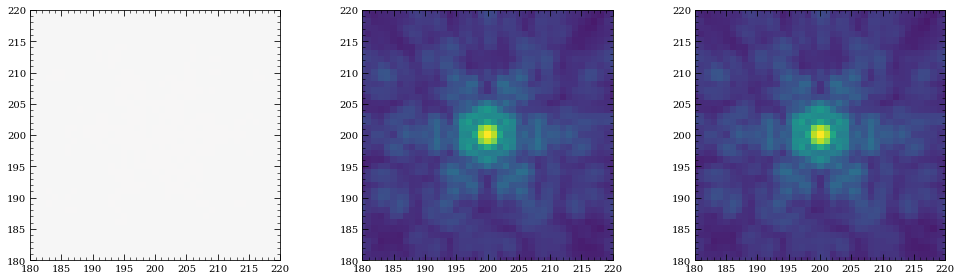

In [62]:
im1 = psf0
im2 = psfs_G0[0]
ratio = im1.sum() / im2.sum()
diff = (im1 - im2*ratio) / im2.sum()

import matplotlib.cm as cm
minmax = 5e-4

fig, axes = plt.subplots(1,3, figsize=(14,4))
axes[0].imshow(diff, vmin=-minmax, vmax=minmax, cmap=cm.RdBu)
axes[1].imshow(im1**0.2)
axes[2].imshow(im2**0.2)

print(ratio, np.min(diff), np.max(diff))

for ax in axes:
    ax.set_xlim([180,220])
    ax.set_ylim([180,220])
    
fig.tight_layout()

In [27]:
print(obs0.countrate()/obs0_norm.countrate(), obs0_norm.effstim('vegamag')-obs0.effstim('vegamag'))

8.628221214280928e+18 47.339803178034416


In [14]:
kwargs

{'fov_pix': 401,
 'oversample': 4,
 'tel_pupil': None,
 'opd': ('OPD_RevW_ote_for_NIRCam_requirements.fits.gz', 0),
 'jitter': 'gaussian',
 'jitter_sigma': 0.007,
 'pupil': 'CLEAR'}

In [15]:
wpsf_a = nrc_utils.gen_webbpsf_siwfe(nrc.filter, (v2_asec[0], v3_asec[0]), **kwargs)
wpsf_b = nrc_utils.gen_webbpsf_siwfe(nrc.filter, (v2_asec[-1], v3_asec[-1]), **kwargs)

NRCB5 (1831.987947898948, 1848.1500601299413)
NRCB5 (1832.3954940684293, 1944.0272786502796)


-0.0001448672452480041 0.000343602273351451


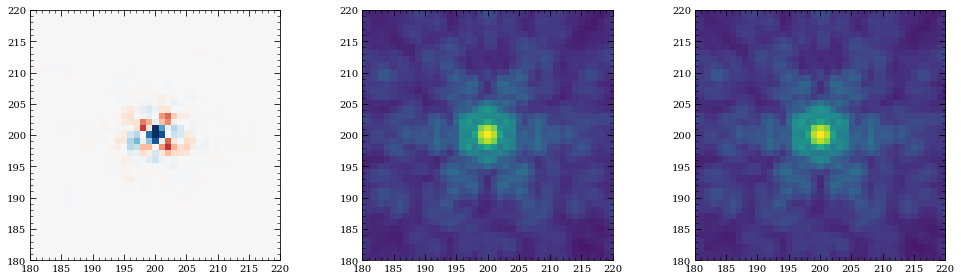

In [16]:
im1 = wpsf_a[1].data
im2 = wpsf_b[1].data
diff = im1 - im2

import matplotlib.cm as cm
minmax = 2e-4

fig, axes = plt.subplots(1,3, figsize=(14,4))
axes[0].imshow(diff, vmin=-minmax, vmax=minmax, cmap=cm.RdBu)
axes[1].imshow(im1**0.2)
axes[2].imshow(im2**0.2)

print(np.min(diff), np.max(diff))

for ax in axes:
    ax.set_xlim([180,220])
    ax.set_ylim([180,220])
    
fig.tight_layout()

-6.809543780388321e-05 9.50669141781546e-05


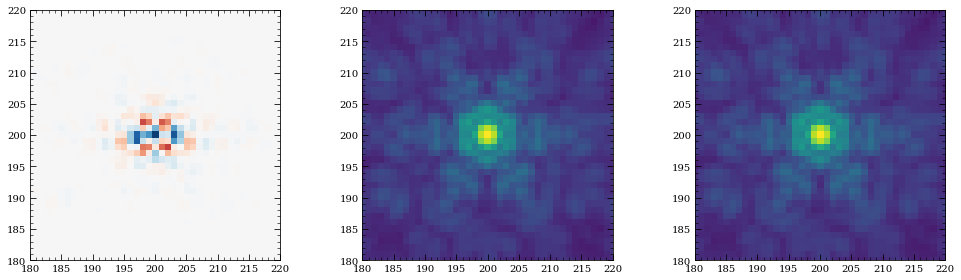

In [17]:
im1 = psf_all[0]
im2 = psf_all[-1]
diff = im1 - im2

import matplotlib.cm as cm
minmax = 1e-4

fig, axes = plt.subplots(1,3, figsize=(14,4))
axes[0].imshow(diff, vmin=-minmax, vmax=minmax, cmap=cm.RdBu)
axes[1].imshow(im1**0.2)
axes[2].imshow(im2**0.2)

print(np.min(diff), np.max(diff))

for ax in axes:
    ax.set_xlim([180,220])
    ax.set_ylim([180,220])
    
fig.tight_layout()

In [23]:
from pynrc import nrc_utils
from pynrc import NIRCam

In [ ]:
class nrc_field_wfe(NIRCam):
    """NIRCam class with field-dependent coefficient

    Subclass of the :mod:`~pynrc.NIRCam` instrument class with updates for PSF
    generation of WFE variations across the field.

    Parameters
    ----------
    wind_mode : str
        'FULL', 'STRIPE', or 'WINDOW'
    xpix : int
        Size of the detector readout along the x-axis. The detector is
        assumed to be in window mode  unless the user explicitly
        sets wind_mode='FULL'.
    ypix : int
        Size of the detector readout along the y-axis. The detector is
        assumed to be in window mode  unless the user explicitly
        sets wind_mode='FULL'.

    """

    def __init__(self, verbose=False, **kwargs):

        #super(NIRCam,self).__init__(**kwargs)
        NIRCam.__init__(self, **kwargs)

        # Background/off-axis PSF coeff updates
        # -------------------------------------
        # Background PSF should be same size as primary PSF
        # Used to generate position-dependent off-axis PSFs
        if self.mask is not None:
            if verbose: print("Generating background PSF coefficients...")
            log_prev = conf.logging_level
            self._fov_pix_bg = self.psf_info['fov_pix']
            setup_logging('WARN', verbose=False)
            self.update_psf_coeff()
            setup_logging(log_prev, verbose=False)

        # Cached PSFs
        # -----------
        # Generate cached PSFs for quick retrieval.
        # A PSF centered on the mask and one fully off-axis.
        if verbose: print("Generating oversampled PSFs...")
        self._gen_cached_psfs()

        # Set locations based on detector
        self._set_xypos()
        # Create mask throughput images seen by each detector
        self._gen_cmask()